In [ ]:
# Introduction
# 사고 자동차 이미지를 수집한 AI 데이터셋으로, 차량 외관 부품의 세그멘테이션과 손상 유형 및 범위를 이해할 수 있는 형태로 가공된 다양한 차종 및 부품에 대한 학습 데이터셋 구축

In [ ]:
# Obgective
# 자동차 사고 시 발생하는 다양한 유형의 사고 이미지로부터 손상 유형, 손상 부위, 손상 심각도를 도출해낼 수 있는 인공지능 개발을 위한 데이터셋

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from glob import glob
from typing import *
from IPython.display import Image as IPImage
from sklearn.model_selection import train_test_split
import random
import os
import shutil
from PIL import Image as Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import ConcatDataset
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F

In [ ]:
# 코랩에서 GPU 사용을 위해서는 별도의 설정이 필요합니다.
# 상단 런타임 -> 런타임 유형 변경의 항목을 통해 CPU대신 사용 가능한 GPU로 하드웨어 가속기를 변경해줍니다.
# 아래 코드는 GPU 사용이 가능한 상태인지 확인하는 코드로, 올바르게 GPU 설정이 되어있다면 TURE, 1이 출력됩니다.
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [ ]:
!nvidia-smi

Fri Nov 29 00:18:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Damaged Veichle Data_Sample.zip 파일을 압축 해제

import zipfile
import os

# 파일 경로를 지정합니다.
zip_file_path = '/content/Damaged Veichle Data_Sample.zip'  # 실제 파일 경로로 변경해야 합니다.

# 압축 해제할 디렉토리 경로를 지정합니다. (현재 디렉토리에 압축을 해제합니다.)
extract_dir = '/content'

# 압축 파일이 존재하는지 확인합니다.
if not os.path.exists(zip_file_path):
    print(f"Error: {zip_file_path} not found.")
else:
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Successfully extracted {zip_file_path} to {extract_dir}")

    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")

Successfully extracted /content/Damaged Veichle Data_Sample.zip to /content


In [ ]:
# /content/Damaged Veichle Data_Sample/labeling data/TL_damage/damage
import json
import glob
import os
import pandas as pd

# JSON 파일 경로 설정
json_path = '/content/Damaged Veichle Data_Sample/labeling data/TL_damage/damage/*.json'

# 모든 JSON 파일 로드
data = []

for file in glob.glob(json_path):
    with open(file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)
        #print(f"Loading data from: {file}")  # 파일 이름 출력

        # 필요한 데이터 추출
        if 'annotations' in json_data:  # annotations 키 확인
            for annotation in json_data['annotations']:
                data.append({
                    'category_id': annotation.get('category_id', None),
                    'damage': annotation.get('damage', None),
                    'color': annotation.get('color', None),
                    #'year': annotation.get('year', None),
                    #'image_id': annotation.get('image_id', None),
                    'file_name': json_data['images']['file_name']  # 이미지 파일 이름 추가
                })

# 데이터프레임 생성
df = pd.DataFrame(data)

In [ ]:
df

,category_id,damage,color,file_name
0,sc-148576,Scratched,White,0369940_sc-148576.jpg
1,sc-148576,Scratched,White,0369940_sc-148576.jpg
2,sc-148576,Scratched,White,0369940_sc-148576.jpg
3,sc-148576,Scratched,White,0369940_sc-148576.jpg
4,sc-163472,Scratched,White,0097870_sc-163472.jpg
...,...,...,...,...
3793,sc-143081,Breakage,White,0141496_sc-143081.jpg
3794,sc-143081,Breakage,White,0141496_sc-143081.jpg
3795,sc-143081,Scratched,White,0141496_sc-143081.jpg
3796,as-2702050,Separated,Blue tone,0250749_as-2702050.jpg


In [ ]:
print(df.to_string(index=False))  # 인덱스 없이 출력

category_id    damage     color              file_name
  sc-148576 Scratched     White  0369940_sc-148576.jpg
  sc-148576 Scratched     White  0369940_sc-148576.jpg
  sc-148576 Scratched     White  0369940_sc-148576.jpg
  sc-148576 Scratched     White  0369940_sc-148576.jpg
  sc-163472 Scratched     White  0097870_sc-163472.jpg
  sc-163472 Scratched     White  0097870_sc-163472.jpg
  sc-163472 Scratched     White  0097870_sc-163472.jpg
  sc-185664 Scratched     White  0179924_sc-185664.jpg
  sc-185664 Scratched     White  0179924_sc-185664.jpg
 as-0062902  Breakage     Black 0228613_as-0062902.jpg
 as-0062902 Separated     Black 0228613_as-0062902.jpg
 as-0062902   Crushed     Black 0228613_as-0062902.jpg
 as-0062902   Crushed     Black 0228613_as-0062902.jpg
 as-0062902 Scratched     Black 0228613_as-0062902.jpg
 as-0062902 Scratched     Black 0228613_as-0062902.jpg
 as-0062902 Scratched     Black 0228613_as-0062902.jpg
 as-0062902 Scratched     Black 0228613_as-0062902.jpg
  sc-15857

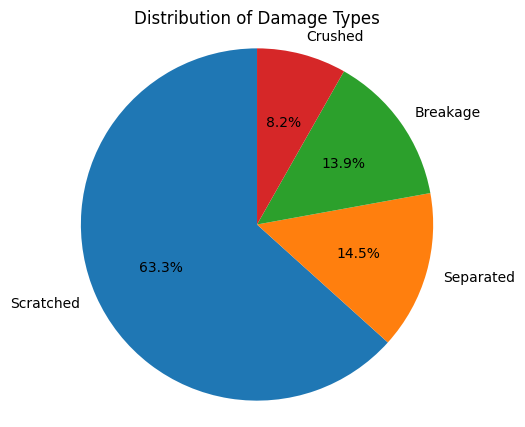

In [ ]:
# prompt: 파이차트로 damage의 비중을 나타내는 코드를 만들어줘

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame as defined in the previous code

# Count the occurrences of each damage type
damage_counts = df['damage'].value_counts()

# Create the pie chart
plt.figure(figsize=(5, 5))  # Adjust figure size as needed
plt.pie(damage_counts, labels=damage_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Damage Types')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# prompt: df에서 filename에 따른 damage 유형을 확인하는 코드를 만들어줘

# Display damage types for each filename
filename_damage = df.groupby('file_name')['damage'].apply(list)
filename_damage

,damage
file_name,
0000459_sc-226797.jpg,[Separated]
0000802_as-7929891.jpg,"[Crushed, Scratched]"
0001061_sc-123724.jpg,"[Separated, Scratched, Scratched, Scratched, S..."
0001146_sc-149689.jpg,[Breakage]
0001505_as-2951606.jpg,"[Breakage, Separated, Separated, Crushed]"
...,...
0505076_sc-207368.jpg,"[Crushed, Scratched, Scratched, Scratched, Cru..."
0505091_as-0100005.jpg,"[Separated, Breakage]"
0505154_as-7511257.jpg,"[Breakage, Scratched]"


In [ ]:
# prompt: filename_damage에서 damage 가 2개 이상 적힌 file_name만 나타내는 코드를 만들어줘

filtered_filenames = filename_damage[filename_damage.apply(len) >= 2]

# 필터링된 파일 이름 출력
filtered_filenames

,damage
file_name,
0000802_as-7929891.jpg,"[Crushed, Scratched]"
0001061_sc-123724.jpg,"[Separated, Scratched, Scratched, Scratched, S..."
0001505_as-2951606.jpg,"[Breakage, Separated, Separated, Crushed]"
0002011_as-0097507.jpg,"[Scratched, Separated]"
0003420_sc-138198.jpg,"[Crushed, Crushed, Scratched, Scratched, Crush..."
...,...
0505076_sc-207368.jpg,"[Crushed, Scratched, Scratched, Scratched, Cru..."
0505091_as-0100005.jpg,"[Separated, Breakage]"
0505154_as-7511257.jpg,"[Breakage, Scratched]"


In [ ]:
# RGBA를 RGB로 변환하여 crop된 사진 파일 생성
import json
import os
from PIL import Image
import glob


In [ ]:

def crop_damages(image_path, json_path, output_dir):

    """
    Crops images based on bounding box coordinates from a JSON file.
    """
    try:
        with open(json_path, 'r') as f:
            json_data = json.load(f)
    except FileNotFoundError:
        print(f"Error: JSON file not found at {json_path}")
        return
    except json.JSONDecodeError:
        print(f"Error: Invalid JSON file at {json_path}")

        return

    try:
        with Image.open(image_path) as img:
            # Convert image to RGB mode if it's RGBA
            if img.mode == 'RGBA':
                img = img.convert('RGB')

            image_name = os.path.splitext(os.path.basename(image_path))[0]

            for i, annotation in enumerate(json_data['annotations']):
                bbox = annotation['bbox']
                damage_type = annotation['damage']
                left, top, width, height = bbox
                right = left + width
                bottom = top + height

                try:
                    cropped_img = img.crop((left, top, right, bottom))
                    # Convert cropped image to RGB if necessary
                    if cropped_img.mode == 'RGBA':
                        cropped_img = cropped_img.convert('RGB')

                    resized_img = cropped_img.resize((50, 50))

                    output_filename = f"{image_name}_{damage_type.lower()}_{i+1}.jpg"
                    output_path = os.path.join(output_dir, output_filename)
                    resized_img.save(output_path, 'JPEG')

                except Exception as e:
                    print(f"Error cropping image {image_path}: {e}")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")


In [ ]:

def process_images(image_dir, json_dir, output_base_dir):

    """
    Processes all images in the specified directory.
    """
    if not os.path.exists(output_base_dir):
        os.makedirs(output_base_dir)

    image_files = glob.glob(os.path.join(image_dir, '*.jpg'))
    for image_path in image_files:
        image_name = os.path.splitext(os.path.basename(image_path))[0]
        json_name = image_name + '.json'
        json_path = os.path.join(json_dir, json_name)

        output_dir = os.path.join(output_base_dir, image_name + "_crops")
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        crop_damages(image_path, json_path, output_dir)


In [ ]:

# Example usage
image_directory = '/content/Damaged Veichle Data_Sample/raw data/TS_damage/damage/'
json_directory = '/content/Damaged Veichle Data_Sample/labeling data/TL_damage/damage/'
output_directory = '/content/crop_images'


In [ ]:
# crop_images 파일 생성
process_images(image_directory, json_directory, output_directory)

분류 모델 만들기

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [ ]:
# def seed_everything(seed):
#     random.seed(seed)  # Python
#     np.random.seed(seed)  # NumPy
#     torch.manual_seed(seed)  # PyTorch
#     torch.cuda.manual_seed(seed)  # PyTorch cuda
#     torch.backends.cudnn.deterministic = True  # CuDNN
#     torch.backends.cudnn.benchmark = False  # CuDNN benchmark

In [ ]:
# seed_everything(seed=32)

------------------------------------------------------------------------------

crop_images 의 사진의 damage를 숫자로 라벨링


In [ ]:
# crop_images 내 파일 모두 불러오기
glob.glob('/content/crop_images/*/*')

['/content/crop_images/0105230_sc-183329_crops/0105230_sc-183329_scratched_4.jpg',
 '/content/crop_images/0105230_sc-183329_crops/0105230_sc-183329_scratched_3.jpg',
 '/content/crop_images/0105230_sc-183329_crops/0105230_sc-183329_scratched_2.jpg',
 '/content/crop_images/0105230_sc-183329_crops/0105230_sc-183329_crushed_1.jpg',
 '/content/crop_images/0484948_sc-132079_crops/0484948_sc-132079_scratched_1.jpg',
 '/content/crop_images/0484948_sc-132079_crops/0484948_sc-132079_scratched_2.jpg',
 '/content/crop_images/0235572_sc-105479_crops/0235572_sc-105479_scratched_1.jpg',
 '/content/crop_images/0235572_sc-105479_crops/0235572_sc-105479_scratched_3.jpg',
 '/content/crop_images/0235572_sc-105479_crops/0235572_sc-105479_scratched_2.jpg',
 '/content/crop_images/0267935_sc-174167_crops/0267935_sc-174167_scratched_3.jpg',
 '/content/crop_images/0267935_sc-174167_crops/0267935_sc-174167_scratched_4.jpg',
 '/content/crop_images/0267935_sc-174167_crops/0267935_sc-174167_scratched_1.jpg',
 '/con

In [ ]:
# 사진에 따른 damage 유형을 데이터 프레임으로 만들기
df_all = pd.DataFrame(glob.glob('/content/crop_images/*/*'), columns=['file_name'])
df_all

,file_name
0,/content/crop_images/0105230_sc-183329_crops/0...
1,/content/crop_images/0105230_sc-183329_crops/0...
2,/content/crop_images/0105230_sc-183329_crops/0...
3,/content/crop_images/0105230_sc-183329_crops/0...
4,/content/crop_images/0484948_sc-132079_crops/0...
...,...
3793,/content/crop_images/0125390_as-7509711_crops/...
3794,/content/crop_images/0068041_sc-230154_crops/0...
3795,/content/crop_images/0068041_sc-230154_crops/0...
3796,/content/crop_images/0068041_sc-230154_crops/0...


In [ ]:
df_all['damage'] = df_all['file_name'].apply(lambda x: x.split('_')[-2])
df_all

,file_name,damage
0,/content/crop_images/0105230_sc-183329_crops/0...,scratched
1,/content/crop_images/0105230_sc-183329_crops/0...,scratched
2,/content/crop_images/0105230_sc-183329_crops/0...,scratched
3,/content/crop_images/0105230_sc-183329_crops/0...,crushed
4,/content/crop_images/0484948_sc-132079_crops/0...,scratched
...,...,...
3793,/content/crop_images/0125390_as-7509711_crops/...,crushed
3794,/content/crop_images/0068041_sc-230154_crops/0...,scratched
3795,/content/crop_images/0068041_sc-230154_crops/0...,scratched
3796,/content/crop_images/0068041_sc-230154_crops/0...,scratched


In [ ]:
# damage type을 {'Separated':0, 'Breakage':1, 'Scratched':2, 'Crushed':3}으로 라벨링
damage_types = {'Separated':0, 'Breakage':1, 'Scratched':2, 'Crushed':3}

In [ ]:
# df_all의 damage를 숫자로 라벨링
df_all['label'] = df_all['damage'].apply(lambda x: damage_types.get(x.capitalize(), -1))
df_all.head()

,file_name,damage,label
0,/content/crop_images/0105230_sc-183329_crops/0...,scratched,2
1,/content/crop_images/0105230_sc-183329_crops/0...,scratched,2
2,/content/crop_images/0105230_sc-183329_crops/0...,scratched,2
3,/content/crop_images/0105230_sc-183329_crops/0...,crushed,3
4,/content/crop_images/0484948_sc-132079_crops/0...,scratched,2


In [ ]:
# 사진의 damage를 숫자로 labeling 한 데이터를 y에 저장하기 --> array
y = df_all['label'].values
y

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
y[:50]

array([2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 1, 2,
       2, 2, 2, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 1, 0, 2,
       1, 2, 0, 2, 2, 2])

In [ ]:
y.shape

(3798,)

In [ ]:
# crop_images 안의 모든 사진의 픽셀을 255로 나누어 정규화한 후, array 형식으로 바꾸어 x에 저장하기
x = np.array([np.array(Image.open(file))/255.0 for file in df_all['file_name']])
x

array([[[[0.42352941, 0.42352941, 0.41568627],
         [0.42745098, 0.42745098, 0.41960784],
         [0.43137255, 0.43137255, 0.42352941],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.43529412, 0.43529412, 0.42745098],
         [0.43529412, 0.43529412, 0.42745098]],

        [[0.43921569, 0.43921569, 0.43137255],
         [0.44313725, 0.44313725, 0.43529412],
         [0.44705882, 0.44705882, 0.43921569],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.43921569, 0.43921569, 0.43137255],
         [0.43921569, 0.43921569, 0.43137255]],

        [[0.44705882, 0.44705882, 0.43921569],
         [0.44705882, 0.44705882, 0.43921569],
         [0.45098039, 0.45098039, 0.44313725],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.42352941, 0.42352941, 0.41568627],
         [0.42352941, 0.42352941, 0.41568627]],

        ...,

        [[0.54117647, 0.54117647, 0.53333333],
         [0.54509804, 0.54509804, 0.5372549 ]

In [ ]:
x[:1]

array([[[[0.42352941, 0.42352941, 0.41568627],
         [0.42745098, 0.42745098, 0.41960784],
         [0.43137255, 0.43137255, 0.42352941],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.43529412, 0.43529412, 0.42745098],
         [0.43529412, 0.43529412, 0.42745098]],

        [[0.43921569, 0.43921569, 0.43137255],
         [0.44313725, 0.44313725, 0.43529412],
         [0.44705882, 0.44705882, 0.43921569],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.43921569, 0.43921569, 0.43137255],
         [0.43921569, 0.43921569, 0.43137255]],

        [[0.44705882, 0.44705882, 0.43921569],
         [0.44705882, 0.44705882, 0.43921569],
         [0.45098039, 0.45098039, 0.44313725],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.42352941, 0.42352941, 0.41568627],
         [0.42352941, 0.42352941, 0.41568627]],

        ...,

        [[0.54117647, 0.54117647, 0.53333333],
         [0.54509804, 0.54509804, 0.5372549 ]

In [ ]:
x.shape

(3798, 50, 50, 3)

In [ ]:
def prepare_data(x):
    # 채널 순서 변경: (batch_size, height, width, channels) -> (batch_size, channels, height, width)
    x = np.transpose(x, (0, 3, 1, 2))
    # NumPy 배열을 PyTorch 텐서로 변환
    x = torch.FloatTensor(x)
    return x

In [ ]:
x[:1]

array([[[[0.42352941, 0.42352941, 0.41568627],
         [0.42745098, 0.42745098, 0.41960784],
         [0.43137255, 0.43137255, 0.42352941],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.43529412, 0.43529412, 0.42745098],
         [0.43529412, 0.43529412, 0.42745098]],

        [[0.43921569, 0.43921569, 0.43137255],
         [0.44313725, 0.44313725, 0.43529412],
         [0.44705882, 0.44705882, 0.43921569],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.43921569, 0.43921569, 0.43137255],
         [0.43921569, 0.43921569, 0.43137255]],

        [[0.44705882, 0.44705882, 0.43921569],
         [0.44705882, 0.44705882, 0.43921569],
         [0.45098039, 0.45098039, 0.44313725],
         ...,
         [0.43137255, 0.43137255, 0.42352941],
         [0.42352941, 0.42352941, 0.41568627],
         [0.42352941, 0.42352941, 0.41568627]],

        ...,

        [[0.54117647, 0.54117647, 0.53333333],
         [0.54509804, 0.54509804, 0.5372549 ]

In [ ]:
# 데이터 분할 (train:0.8, validation:0.1, test:0.1)
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False, random_state=42)


In [ ]:
# 필요한 라이브러리 호출
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [ ]:

# 커스텀 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = np.transpose(self.images[idx], (2, 0, 1))
        return torch.FloatTensor(image), torch.LongTensor([self.labels[idx]])[0]


In [ ]:

# Early Stopping 클래스
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience

        # 최소 개선치
        self.min_delta = min_delta

        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = model.state_dict()
            #self.counter = 0

        # 최소 개선치보다 적게 개선된 경우
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
          self.best_loss = val_loss
          self.best_model = model.state_dict()
          self.counter = 0


         # 최상의 검증 정확도를 기록하고 모델 저장 : EarlyStopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model_before.pth')
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:  # 설정한 얼리 스타핑 patience에 도달하면 학습을 중단합니다.
            print("Early stopping")
            break


In [ ]:

# ResNet18 모델 생성
def create_resnet_model(num_classes=4):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model


In [ ]:

# 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    early_stopping = EarlyStopping()
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        # 학습
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

        # 검증
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        # 결과 저장
        train_loss = train_loss/len(train_loader)
        val_loss = val_loss/len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}')

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break

    return history


In [ ]:

# 데이터 로더 생성
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [ ]:
# 테스트 셋 평가 함수
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_loss = test_loss/len(test_loader)
    test_acc = test_correct / test_total
    return test_loss, test_acc


In [ ]:

# 모델 학습
model = create_resnet_model()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
history = train_model(model, train_loader, val_loader, criterion, optimizer)


Epoch [1/100]
Train Loss: 1.0545, Train Acc: 0.63
Val Loss: 0.9286, Val Acc: 0.68
Epoch [2/100]
Train Loss: 0.7497, Train Acc: 0.73
Val Loss: 0.7839, Val Acc: 0.71
Epoch [3/100]
Train Loss: 0.6613, Train Acc: 0.76
Val Loss: 0.7480, Val Acc: 0.71
Epoch [4/100]
Train Loss: 0.5221, Train Acc: 0.82
Val Loss: 0.7110, Val Acc: 0.76
Epoch [5/100]
Train Loss: 0.4169, Train Acc: 0.86
Val Loss: 1.0172, Val Acc: 0.67
Epoch [6/100]
Train Loss: 0.3546, Train Acc: 0.87
Val Loss: 0.8264, Val Acc: 0.73
Epoch [7/100]
Train Loss: 0.3010, Train Acc: 0.90
Val Loss: 0.7388, Val Acc: 0.77
Epoch [8/100]
Train Loss: 0.2001, Train Acc: 0.93
Val Loss: 0.7326, Val Acc: 0.76
Epoch [9/100]
Train Loss: 0.1968, Train Acc: 0.93
Val Loss: 0.8391, Val Acc: 0.77
Epoch [10/100]
Train Loss: 0.1728, Train Acc: 0.94
Val Loss: 0.8176, Val Acc: 0.79
Epoch [11/100]
Train Loss: 0.1218, Train Acc: 0.96
Val Loss: 1.2153, Val Acc: 0.69
Epoch [12/100]
Train Loss: 0.1374, Train Acc: 0.96
Val Loss: 0.9578, Val Acc: 0.75
Epoch [13/100

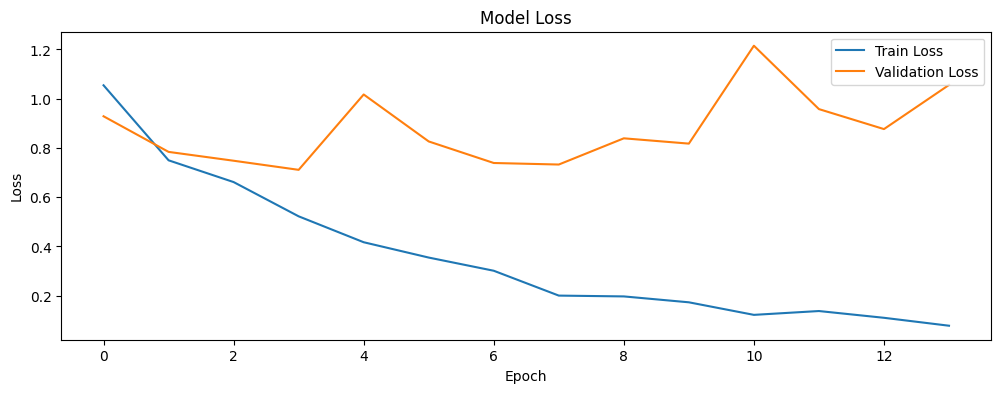

In [ ]:

# 학습 결과 시각화
plt.figure(figsize=(12, 4))

# Loss 그래프
#plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


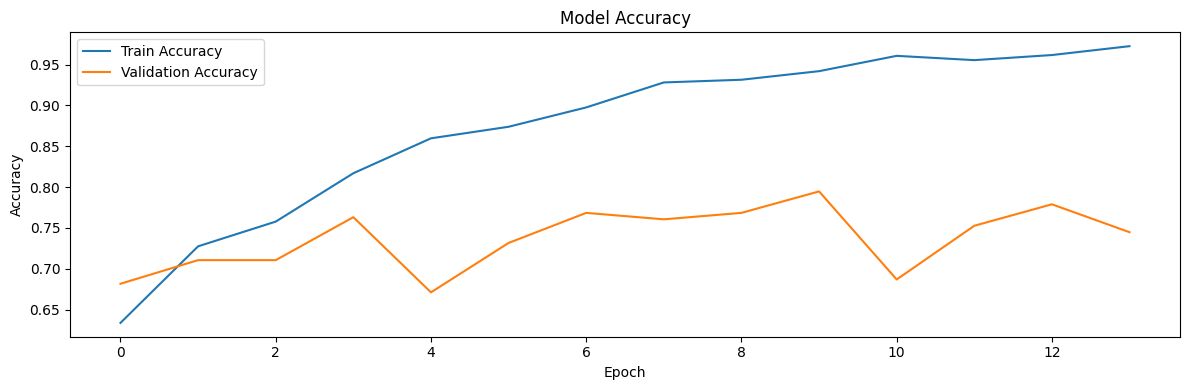

In [ ]:

# Accuracy 그래프
plt.figure(figsize=(12, 4))
#plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

test_accuracy = 100. * correct / total
f1 = f1_score(all_labels, all_preds, average='weighted')


NameError: name 'correct' is not defined

In [ ]:

#print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'F1 Score: {f1:.4f}')

NameError: name 'f1' is not defined

In [ ]:
model.evaluate(X_test, y_test) # 학습시간 감소 및 과적합 방지

AttributeError: 'ResNet' object has no attribute 'evaluate'

----------------------------------------------------------